# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import numba
%matplotlib inline


In [2]:
from LightTransportSimulator.light_transport.src.primitives import Sphere
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_sphere_box, get_cornell_box
from LightTransportSimulator.light_transport.src.constants import *
from LightTransportSimulator.light_transport.src.material import Material
from LightTransportSimulator.light_transport.src.vectors import normalize

In [3]:
WHITE_COLOR = Color(ambient=np.array([1, 1, 1], dtype=np.float64),
                    diffuse=np.array([1, 1, 1], dtype=np.float64),
                    specular=np.array([1, 1, 1], dtype=np.float64))

NO_COLOR = Color(ambient=np.array([0, 0, 0], dtype=np.float64),
                 diffuse=np.array([0, 0, 0], dtype=np.float64),
                 specular=np.array([0, 0, 0], dtype=np.float64))


RED_COLOR = Color(ambient=np.array([.75, .25, .25], dtype=np.float64),
                  diffuse=np.array([.75, .25, .25], dtype=np.float64),
                  specular=np.array([.75, .25, .25], dtype=np.float64))

GREEN_COLOR = Color(ambient=np.array([.25, .75, .25], dtype=np.float64),
                  diffuse=np.array([.25, .75, .25], dtype=np.float64),
                  specular=np.array([.25, .75, .25], dtype=np.float64))

BLUE_COLOR = Color(ambient=np.array([.25, .25, .75], dtype=np.float64),
                   diffuse=np.array([.25, .25, .75], dtype=np.float64),
                   specular=np.array([.25, .25, .75], dtype=np.float64))

GRAY_COLOR = Color(ambient=np.array([.75, .75, .75], dtype=np.float64),
                   diffuse=np.array([.75, .75, .75], dtype=np.float64),
                   specular=np.array([.75, .75, .75], dtype=np.float64))

GRAY_COLOR2 = Color(ambient=np.array([.25, .25, .25], dtype=np.float64),
                   diffuse=np.array([.25, .25, .25], dtype=np.float64),
                   specular=np.array([.25, .25, .25], dtype=np.float64))

GLASS_COLOR = Color(ambient=np.array([.999, .999, .999], dtype=np.float64),
                    diffuse=np.array([.999, .999, .999], dtype=np.float64),
                    specular=np.array([.999, .999, .999], dtype=np.float64))

In [4]:
from LightTransportSimulator.light_transport.src.scene import Light
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# # Create a global light source

source_mat = Material(color=WHITE_COLOR, shininess=1, ior=1.5, type=MatType.NONE.value, emission=12)
light_sphere = Sphere(center=np.array([50, 681.6-.27, 81.6], dtype=np.float64), radius=600, material=source_mat)

# Light source within Cornell Box is a spherical cap

# hypotenuse = radius of the light sphere, light_disk_radius = radius of the base of the cap
# https://mathworld.wolfram.com/SphericalCap.html
cornell_box_top_y = 81.6

_h = cornell_box_top_y - (light_sphere.center[1] - light_sphere.radius) # height of sphere cap

light_disk_radius = np.sqrt(_h*(2*light_sphere.radius-_h))

light_area = 2 * np.pi * light_sphere.radius * _h

light_disk_center = np.array([50, cornell_box_top_y-_h, 81.6], dtype=np.float64)

light_normal = normalize(light_disk_center - light_sphere.center)

light_samples_n = 100

lights = numba.typed.List()

for i in range(light_samples_n):
    _l = Light(light_sphere.center, light_disk_radius, light_sphere.material, light_normal, light_area)
    lights.append(_l)

_h, light_disk_center, light_disk_radius

(0.2699999999999534, array([50.  , 81.33, 81.6 ]), 17.99797488607938)

In [5]:
lights[0].source

array([ 50.  , 681.33,  81.6 ])

In [6]:
from LightTransportSimulator.light_transport.src.scene import Camera, SphereScene

# Setup scene

# point camera
camera_pos = np.array([50, 52, 295.6], dtype=np.float64)
camera = Camera(camera_pos)

# screen 16:9
width=256
height=192
width = 1024
height = 768

# max_depth is the conventional term used in rendering to denote
# the maximum number of times a ray can bounce within the scene
max_depth=7
# number of samples per pixel
n_samples = 16

# Initialise the scene with lights and camera
scene = SphereScene(camera=camera, lights=lights, width=width, height=height, max_depth=max_depth, f_distance=1, number_of_samples=n_samples//4)

In [7]:

# T = np.array([
#     [1, 0, 0, 50],
#     [0, 1, 0, 40.8],
#     [0, 0, 1, 81.6],
#     [0, 0, 0, 1]
# ], dtype=np.float64)


T = np.array([
    [1, 0, 0, 50],
    [0, 1, 0, 60],
    [0, 0, 1, 81.6],
    [0, 0, 0, 1]
], dtype=np.float64)


scene.t_matrix = T
scene.t_matrix

array([[ 1. ,  0. ,  0. , 50. ],
       [ 0. ,  1. ,  0. , 60. ],
       [ 0. ,  0. ,  1. , 81.6],
       [ 0. ,  0. ,  0. ,  1. ]])

In [8]:
# Set wall colors and materials for the Cornell box

surface_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
left_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
right_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
front_wall_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)

# Get the triangles required to render the Cornell box
spheres = get_cornell_sphere_box(scene, surface_mat, left_wall_mat, right_wall_mat, front_wall_mat)

In [9]:
spheres.append(light_sphere)

In [10]:
# Add the triangles in the list of objects
PLASTIC = Material(color=GREEN_COLOR, shininess=10, ior=1.460, type=MatType.DIFFUSE.value, emission=0)
GLASS = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.SPECULAR.value, emission=0)
MIRROR = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.MIRROR.value, emission=0)
ALUMINUM = Material(color=GRAY_COLOR2, shininess=50, ior=1.400, type=MatType.SPECULAR.value, emission=0)

In [11]:
# sphere_1 = Sphere(center=np.array([27, 16.5, 47], dtype=np.float64), radius=16.5, material=MIRROR)
# spheres.append(sphere_1)
# sphere_2 = Sphere(center=np.array([73, 16.5, 78], dtype=np.float64), radius=16.5, material=GLASS)
sphere_2 = Sphere(center=np.array([50, 16.5, 81.6], dtype=np.float64), radius=16.5, material=GLASS)
spheres.append(sphere_2)
# sphere_3 = Sphere(center=np.array([50, 54, 81.6], dtype=np.float64), radius=22, material=PLASTIC)
# spheres.append(sphere_3)

In [12]:
triangles = numba.typed.List()

C:\Users\dipanjan\Anaconda3\envs\dsenv\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


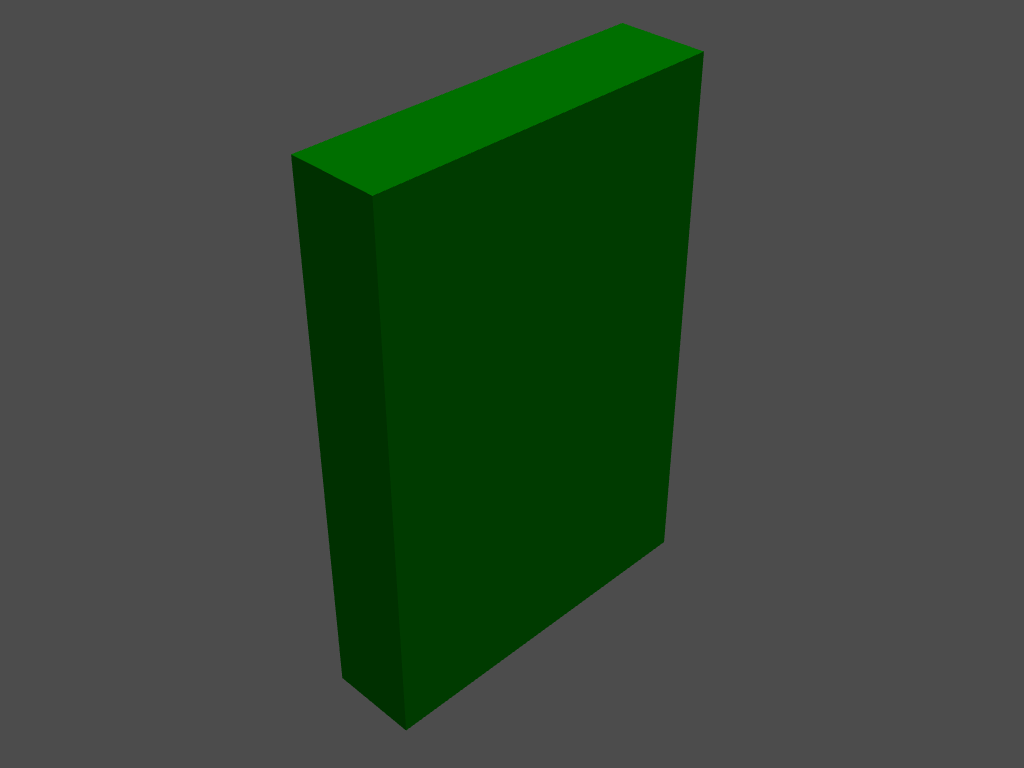

In [145]:
# load a 3D object using PyVista
import pyvista as pv

# _center = np.array([50, 54, 81.6], dtype=np.float64)

mesh = pv.Cube(x_length=8, y_length=2, z_length=12)

plotter = pv.Plotter()

plotter.add_mesh(mesh, color='green')

# Show the plotter window
plotter.show()

In [146]:
tri = mesh.triangulate()
scale_factor = [10.0, 10.0, 10.0]
tri = tri.scale(scale_factor)
points = np.ascontiguousarray(tri.points)
points

C:\Users\dipanjan\Anaconda3\envs\dsenv\lib\site-packages\pyvista\core\pointset.py:261: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)


array([[-40., -10., -60.],
       [-40., -10.,  60.],
       [-40.,  10.,  60.],
       [-40.,  10., -60.],
       [ 40., -10., -60.],
       [ 40.,  10., -60.],
       [ 40.,  10.,  60.],
       [ 40., -10.,  60.]], dtype=float32)

In [147]:
tri = tri.transform(scene.t_matrix)
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
points

array([[ 10. ,  50. ,  21.6],
       [ 10. ,  50. , 141.6],
       [ 10. ,  70. , 141.6],
       [ 10. ,  70. ,  21.6],
       [ 90. ,  50. ,  21.6],
       [ 90. ,  70. ,  21.6],
       [ 90. ,  70. , 141.6],
       [ 90. ,  50. , 141.6]], dtype=float32)

In [170]:
from LightTransportSimulator.light_transport.src.primitives import Triangle

for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                        vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                        vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                        material=PLASTIC)
    triangles.append(triangle)

len(triangles)

12

In [149]:
triangles[0].normal

array([-1.,  0.,  0.])

In [13]:
from LightTransportSimulator.light_transport.src.bvh_new import BoundedBox, BVHNode, build_bvh, LinearBVHNode, flatten_bvh, intersect_bvh

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(triangles)):
    bounded_boxes.append(BoundedBox(triangles[i], i))

len(triangles), len(bounded_boxes)

(0, 0)

In [14]:
if len(triangles)>0:
    # Initialise a bounding volume hierarchy tree
    start = 0
    end = len(bounded_boxes)
    ordered_prims = []
    total_nodes = 0
    root, bounded_boxes, ordered_prims, total_nodes = build_bvh(triangles, bounded_boxes, start, end, ordered_prims, total_nodes)
    # swap the primitives array with the ordered list
    primitives = ordered_prims


    # create a linear representation of the bvh tree
    linear_nodes = numba.typed.List()
    for _ in range(total_nodes):
        linear_nodes.append(LinearBVHNode())


    # linear bvh
    linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
    # len(linear_bvh)

    # check if indexes of all primitives present in the linear bvh tree
    total = 0
    for _bvh in linear_bvh:
        total+= _bvh.n_primitives
    print(total==len(triangles)) # should be equal to the number of primitives
else:
    linear_bvh = None
    triangles = None

In [15]:
from LightTransportSimulator.light_transport.src.global_illumination import render_scene
# from LightTransportSimulator.light_transport.src.render_old import render_scene

start = time.time()
# primitives = spheres, triangles
image = render_scene(scene, spheres, triangles, linear_bvh)
image = np.flipud(image) # flipped
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:144: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:144: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:144: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)


0.012.516297262059974

50.065189048239894
87.6140808344198275.09778357235984
62.58148631029987
37.54889178617992
25.032594524119947

37.67926988265971
12.646675358539765
25.16297262059974
50.19556714471969
0.1303780964797914
75.22816166883963
62.71186440677966
87.74445893089961
12.777053455019557
37.809647979139505
25.29335071707953
50.32594524119948
0.2607561929595828
75.35853976531942
62.84224250325945
87.8748370273794
12.907431551499348
25.423728813559322
37.94002607561929
50.45632333767927
0.39113428943937417
62.972620599739244
75.48891786179922
88.00521512385919
13.03780964797914
25.554106910039113
38.07040417209909
50.58670143415906
0.5215123859191656
63.10299869621903
75.61929595827901
88.13559322033899
13.168187744458931
25.684485006518905
38.20078226857888
50.717079530638856
0.651890482398957
63.23337679269883
75.7496740547588
88.26597131681878
13.298565840938723
25.814863102998697
38.33116036505867
50.847457627118644
0.7822685788787483
63.363754889178615
75.88005215123859
88.

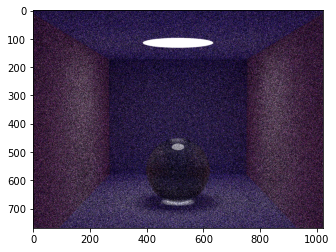

In [16]:
plt.imshow(image)

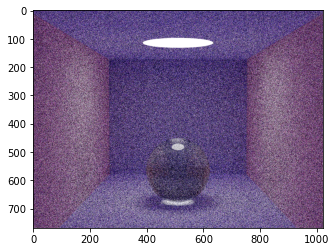

In [17]:
# gamma correction
img_corrected = np.clip(255.0 * np.power(image, 1.0 / 2.2), a_min=0.0, a_max=255.0).astype(int)
plt.imshow(img_corrected)

In [18]:
from LightTransportSimulator.light_transport.src.bdpt import render_scene
# from LightTransportSimulator.light_transport.src.render_old import render_scene

start = time.time()
# primitives = spheres, triangles
image = render_scene(scene, spheres, triangles, linear_bvh)
image = np.flipud(image) # flipped
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\bdpt.py:437: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  camera_vertices = generate_camera_subpaths(scene, bvh, spheres, triangles, cam_ray, scene.max_depth+2)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\bdpt.py:451: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  Lp = connect_paths(scene, spheres, triangles, bvh, camera_vertices, light_vertices, s, t)


0.050.065189048239894
25.032594524119947
87.61408083441982
12.51629726205997437.5488917861799275.09778357235984
62.58148631029987



12.646675358539765
0.1303780964797914
50.19556714471969
25.16297262059974
37.67926988265971
75.22816166883963
87.74445893089961
62.71186440677966
12.777053455019557
0.2607561929595828
37.809647979139505
62.84224250325945
50.32594524119948
75.35853976531942
87.8748370273794
25.29335071707953
0.39113428943937417
12.907431551499348
37.94002607561929
62.972620599739244
50.45632333767927
75.48891786179922
88.00521512385919
25.423728813559322
13.03780964797914
38.07040417209909
0.5215123859191656
63.10299869621903
50.58670143415906
75.61929595827901
88.13559322033899
25.554106910039113
38.20078226857888
13.168187744458931
63.23337679269883
0.651890482398957
75.7496740547588
50.717079530638856
88.26597131681878
25.684485006518905
38.33116036505867
0.7822685788787483
63.363754889178615
13.298565840938723
75.88005215123859
50.847457627118644
88.39634941329857
25.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


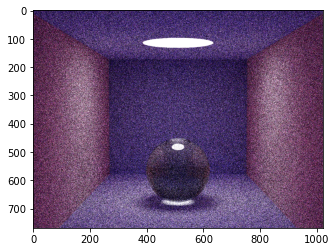

In [19]:
plt.imshow(image)

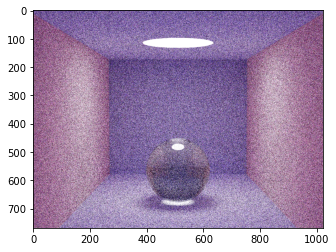

In [20]:
# gamma correction
img_corrected = np.clip(255.0 * np.power(image, 1.0 / 2.2), a_min=0.0, a_max=255.0).astype(int)
plt.imshow(img_corrected)